In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats as st
import arviz as az
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None  # default='warn'

from helper_functions import *

# Simulated data

In [2]:
root_dir = os.getcwd()

data_dir = "/computational_model_data/"

target_string = "output"

runs = []

for subdir, dirs, files in os.walk(root_dir+data_dir):
    for file in files:
        if target_string in file:
            runs.append(file)

In [3]:
simulated_data = pd.DataFrame()

for file_name in runs:
    temp = file_name.split("_")
    code = temp[4]
    level = temp[5]

    temp_data = pd.read_csv(f"{root_dir}/computational_model_data/{file_name}", index_col=False)
    temp_data['convolution_granularity'] = code
    temp_data['level'] = level

    simulated_data = pd.concat([simulated_data, temp_data])

In [4]:
simulated_action_goals = simulated_data[simulated_data.action_goal_selected == True]

In [5]:
spaceship_center_x=954 + 14 # 658 + 14
spaceship_center_y=270 + 14 # 288 + 14

# annotate distance to spaceship
simulated_action_goals["distance_to_spaceship_in_pixel"] = np.sqrt(
    np.power((simulated_action_goals.action_goal_x - spaceship_center_x), 2) +
    np.power((simulated_action_goals.action_goal_y - spaceship_center_y), 2))
simulated_action_goals["distance_to_spaceship"] = simulated_action_goals['distance_to_spaceship_in_pixel'].apply(lambda x: pixel_to_degree(x))
simulated_action_goals["distance_to_spaceship_log"] = np.log(simulated_action_goals.distance_to_spaceship)


## Experimental data

In [6]:
fix_data = pd.read_csv('eye_data/experimental_eye_data_fixations.csv', index_col=False)
distant_fixations = fix_data[fix_data.exploring_fixation == 1]
DistFix_no_drift = distant_fixations[distant_fixations.N_visible_drift_tiles == 0]
DistFix_no_drift['distance_to_spaceship_log'] = np.log(DistFix_no_drift.distance_to_spaceship)

# Plotting

In [7]:
# game features:
scaling=18
edge=34
observation_space_x=40
observation_space_y=60
bottom_edge=15

In [8]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_3725/3033088821.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  target_fixations_human = exp_dat[DistFix_no_drift["converging_eye_x_adjusted"].between(x_bounds[0], x_bounds[1])]
/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_3725/3033088821.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  target_fixations_human = exp_dat[DistFix_no_drift["converging_eye_x_adjusted"].between(x_bounds[0], x_bounds[1])]
/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_3725/3033088821.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  target_fixations_human = exp_dat[DistFix_no_drift["converging_eye_x_adjusted"].between(x_bounds[0], x_bounds[1])]
/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_3725/3033088821.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  target_fixations_h

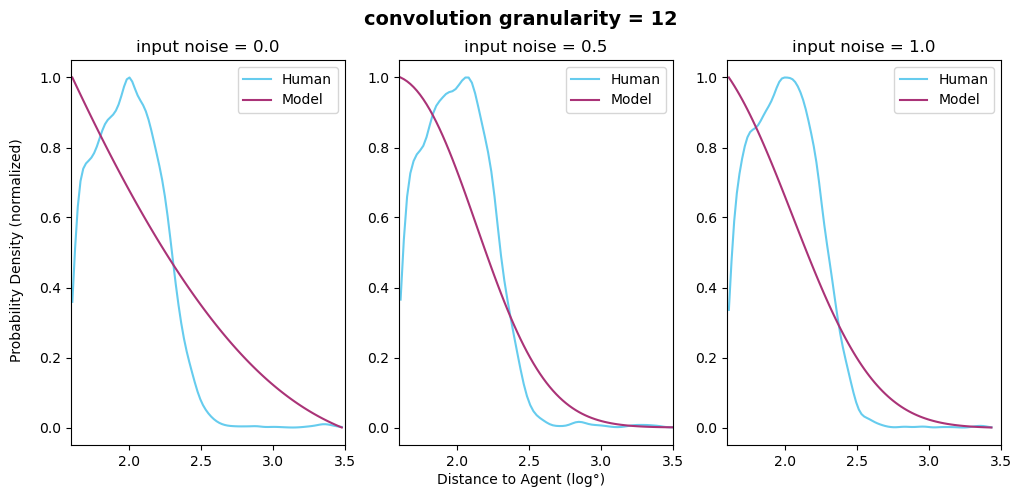

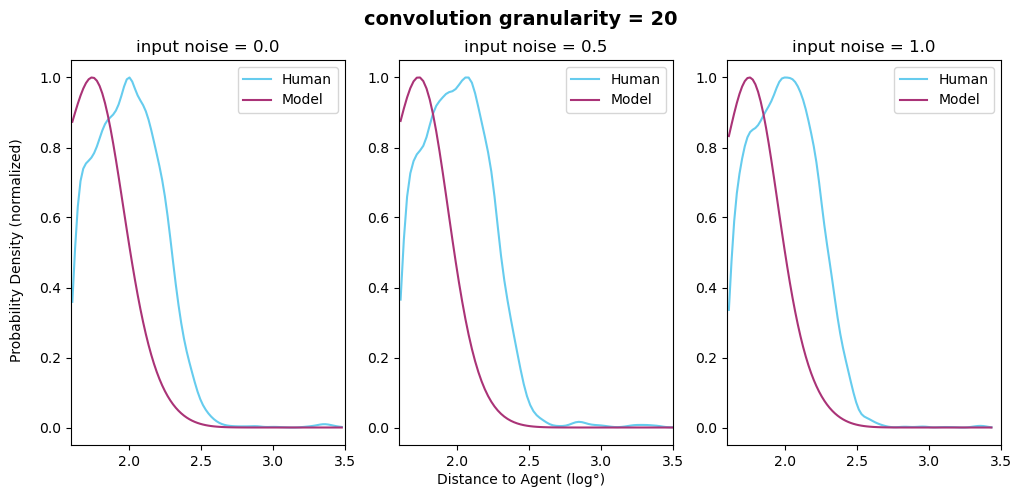

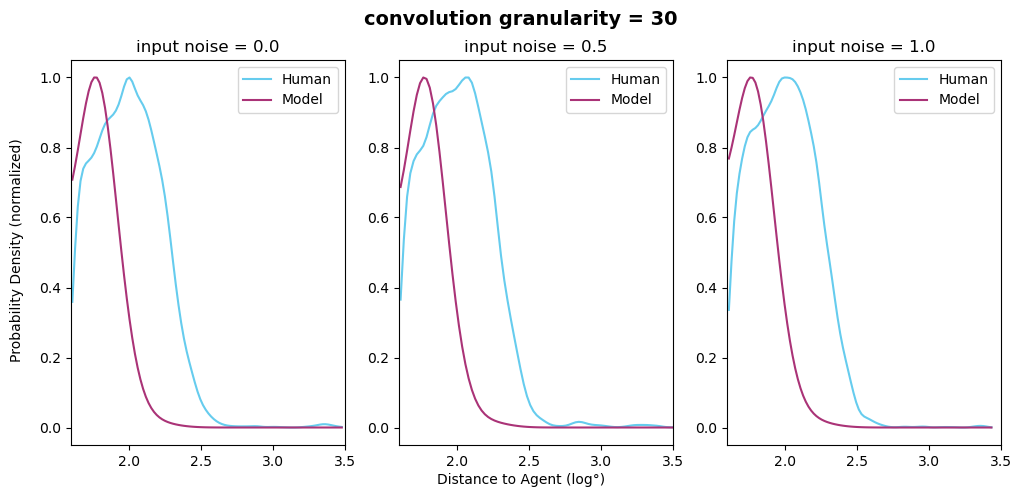

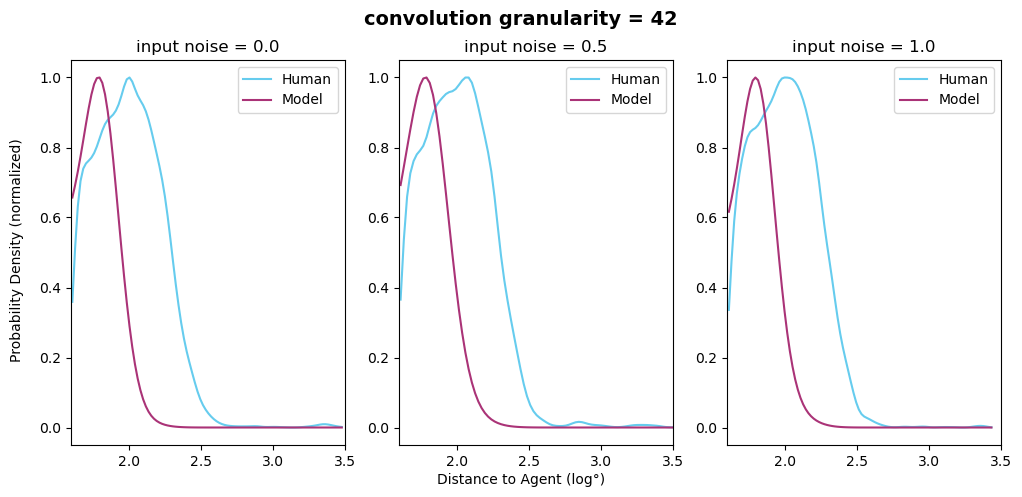

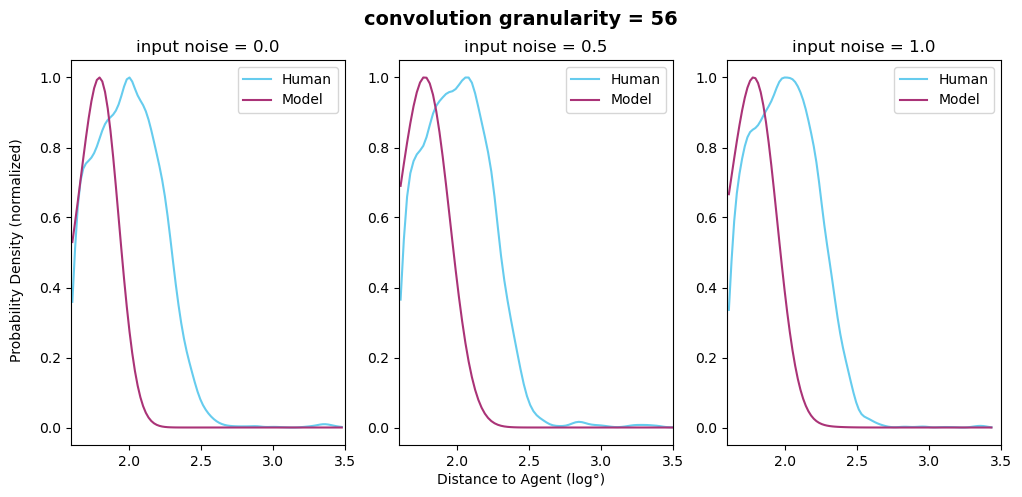

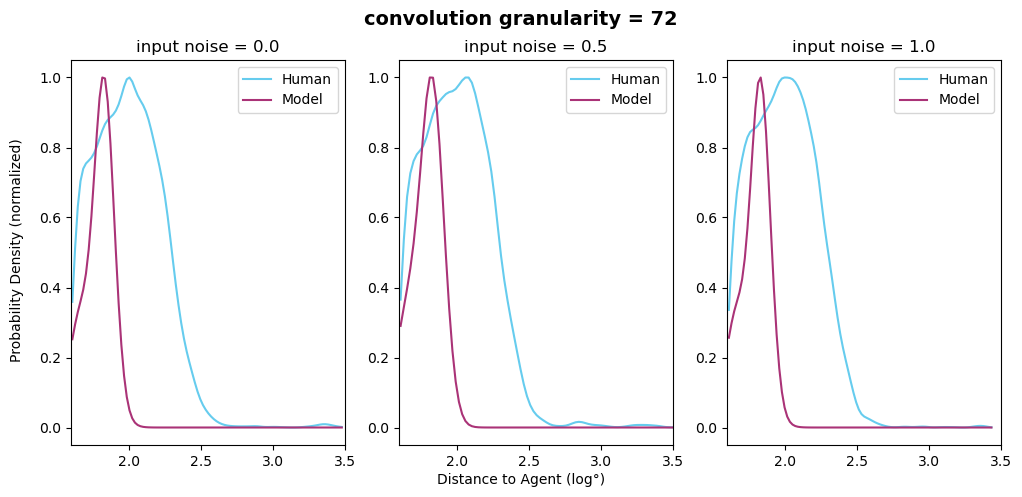

In [25]:
# individual plots
for convolution_granularity in ['12', '20', '30', '42', '56', '72']:
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    fig.suptitle(f'convolution granularity = {convolution_granularity}', weight="bold", fontsize=14)
    
    # axis labels    
    fig.text(0.5, 0.04, 'Distance to Agent (log°)', ha='center', va='center')
    fig.text(0.08, 0.5, 'Probability Density (normalized)', ha='center', va='center', rotation='vertical')
    
    for input_noise, input_noise_magnitude, subplot_pos in zip(['N', 'W', 'S'], [0.0, 0.5, 1.0], [0, 1, 2]):
        
        exp_dat = DistFix_no_drift[DistFix_no_drift.input_noise == input_noise]
        sim_dat = simulated_action_goals[(simulated_action_goals.convolution_granularity == convolution_granularity) & (simulated_action_goals.input_noise_magnitude == input_noise_magnitude)]

        # initiate plot 
        ax[subplot_pos].set_title(f"input noise = {input_noise_magnitude}", fontsize=12)

        x_bounds = [edge*scaling, (edge+observation_space_x)*scaling]
        y_bounds = [0, (observation_space_y - bottom_edge)*scaling]

        ax[subplot_pos].set_xlim([1.6, 3.5])

        # check for fixation within game boarders
        target_fixations_human = exp_dat[DistFix_no_drift["converging_eye_x_adjusted"].between(x_bounds[0], x_bounds[1])]
        
        # sampling
        kde_human = st.gaussian_kde(np.asarray(target_fixations_human.distance_to_spaceship_log))
        kde_model = st.gaussian_kde(np.asarray(sim_dat.distance_to_spaceship_log))
        
        dist_space = np.linspace(min(target_fixations_human.distance_to_spaceship_log), max(target_fixations_human.distance_to_spaceship_log), 100 )

        prob_dens_human_normalized = NormalizeData(kde_human(dist_space))
        prob_dens_model_normalized = NormalizeData(kde_model(dist_space))
        
        # not normalized
        #ax[subplot_pos].plot( dist_space, kde_human(dist_space), label="Human", color='#66CCEE')
        #ax[subplot_pos].plot( dist_space, kde_model(dist_space), label="Model", color='#AA3377')
          
        # vs. normalized
        ax[subplot_pos].plot( dist_space, prob_dens_human_normalized, label="Human", color='#66CCEE')
        ax[subplot_pos].plot( dist_space, prob_dens_model_normalized, label="Model", color='#AA3377')
        
        # points of highest density
        #point_estimate_human = point_estimate(target_fixations_human.distance_to_spaceship_log)[0]
        #ax[subplot_pos].axvline(point_estimate_human, color='blue')
        
        #point_estimate_model = point_estimate(sim_dat.distance_to_spaceship_log)[0]
        #ax[subplot_pos].axvline(point_estimate_model, color='red')
        
        ax[subplot_pos].legend()


### Big plot

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_1182/3331058679.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  target_fixations_human = exp_dat[DistFix_no_drift["converging_eye_x_adjusted"].between(x_bounds[0], x_bounds[1])]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_1182/3331058679.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  target_fixations_human = exp_dat[DistFix_no_drift["converging_eye_x_adjusted"].between(x_bounds[0], x_bounds[1])]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_1182/3331058679.py:40: UserWarning: Boolean Series key will be reindexed to mat

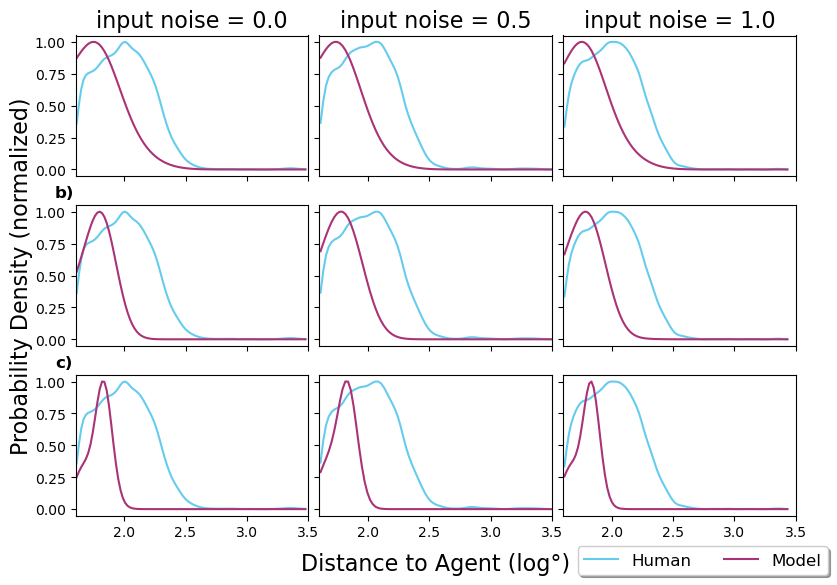

In [37]:

fig, ax = plt.subplots(3, 3, figsize=(9, 6))
#fig.suptitle(f'convolution granularity = {convolution_granularity}', weight="bold", fontsize=14)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.05, 
                    hspace=0.21)

# axis labels    
fig.text(0.5, 0.02, 'Distance to Agent (log°)', ha='center', va='center', fontsize=16)
fig.text(0.04, 0.5, 'Probability Density (normalized)', ha='center', va='center', rotation='vertical', fontsize=16)

#row_titles = ['a) [20]', 'b) [56]', 'c) [72]']
row_titles = ['a)', 'b)', 'c)']

row = 0

for convolution_granularity in ['20', '56', '72']:
    
    #ax[row][0].set_title(f'{row_titles[row]}', weight="bold", loc='left', fontsize=12)
    ax[row][0].set_title(f'{row_titles[row]}', weight="bold", x=-0.05, fontsize=12)
    
    for input_noise, input_noise_magnitude, subplot_pos in zip(['N', 'W', 'S'], [0.0, 0.5, 1.0], [0, 1, 2]):
        
        exp_dat = DistFix_no_drift[DistFix_no_drift.input_noise == input_noise]
        sim_dat = simulated_action_goals[(simulated_action_goals.convolution_granularity == convolution_granularity) & (simulated_action_goals.input_noise_magnitude == input_noise_magnitude)]

        # initiate plot 
        if row == 0:
            ax[row][subplot_pos].set_title(f"input noise = {input_noise_magnitude}", x=0.5, fontsize=16)

        x_bounds = [edge*scaling, (edge+observation_space_x)*scaling]
        y_bounds = [0, (observation_space_y - bottom_edge)*scaling]

        ax[row][subplot_pos].set_xlim([1.6, 3.5])

        # check for fixation within game boarders
        target_fixations_human = exp_dat[DistFix_no_drift["converging_eye_x_adjusted"].between(x_bounds[0], x_bounds[1])]
        
        # sampling
        kde_human = st.gaussian_kde(np.asarray(target_fixations_human.distance_to_spaceship_log))
        kde_model = st.gaussian_kde(np.asarray(sim_dat.distance_to_spaceship_log))
        
        dist_space = np.linspace(min(target_fixations_human.distance_to_spaceship_log), max(target_fixations_human.distance_to_spaceship_log), 100 )

        prob_dens_human_normalized = NormalizeData(kde_human(dist_space))
        prob_dens_model_normalized = NormalizeData(kde_model(dist_space))
        
        # not normalized
        #ax[subplot_pos].plot( dist_space, kde_human(dist_space), label="Human", color='#66CCEE')
        #ax[subplot_pos].plot( dist_space, kde_model(dist_space), label="Model", color='#AA3377')
          
        # vs. normalized
        ax[row][subplot_pos].plot( dist_space, prob_dens_human_normalized, label="Human", color='#66CCEE')
        ax[row][subplot_pos].plot( dist_space, prob_dens_model_normalized, label="Model", color='#AA3377')
        
        if subplot_pos == 0:
            plt.setp(ax[row][subplot_pos].get_yticklabels(), visible=True)
        else:
            plt.setp(ax[row][subplot_pos].get_yticklabels(), visible=False)
        
        if row == 2:
            plt.setp(ax[row][subplot_pos].get_xticklabels(), visible=True)
        else:
            plt.setp(ax[row][subplot_pos].get_xticklabels(), visible=False)
        
        #ax[1][2].legend()
        #box = ax[1][2].get_position()
        #ax[1][2].set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax[2][2].legend(loc='upper center', bbox_to_anchor=(0.6, -0.16),
          fancybox=True, shadow=True, ncol=2, fontsize=12)
        
    row += 1


In [38]:
# works for multiple metrics:

def calc_likelihood(s_star, s, single_stat=False, debugme="nope"):
    # calculates a single likelihood from data statistics s
    # and model replicate statistics s_star

    s = np.matrix(s).transpose()
    if debugme == "debug":
        print("s")
        print(s)
    
    # if only a single metric is used to calculate the likelihood, do not apply .transpose()
    if single_stat:
        s_star = np.matrix(s_star)
    else:
        s_star = np.matrix(s_star).transpose()
    if debugme == "debug":
        print("s_star")
        print(s_star)

    mu_hat = np.mean(s_star, axis=1)  # axis = 1 for ->
    if debugme == "debug":
        print("mu_hat")
        print(mu_hat)

    S = s_star - mu_hat
    if debugme == "debug":
        print("S")
        print(S)

    Sigma_hat = np.dot(S, np.transpose(S)) / (np.shape(S)[1] - 1)
    if debugme == "debug":
        print("Sigma_hat")
        print(Sigma_hat)

    tmp1 = np.transpose(-1 / 2 * (s - mu_hat))
    if debugme == "debug":
        print("tmp1")
        print(tmp1)

    if np.linalg.cond(Sigma_hat) < (1 / sys.float_info.epsilon):
        tmp2 = np.linalg.inv(Sigma_hat)
    else:
        tmp2 = np.linalg.pinv(Sigma_hat)
    tmp2 = np.linalg.inv(Sigma_hat)
    if debugme == "debug":
        print("tmp2")
        print(tmp2)

    tmp3 = (s - mu_hat)
    if debugme == "debug":
        print("tmp3")
        print(tmp3)

    tmp4 = -1 / 2 * np.log(np.linalg.norm(Sigma_hat))
    if debugme == "debug":
        print("tmp4")
        print(tmp4)

    l_s = np.dot(np.dot(tmp1, tmp2), tmp3) + tmp4

    if debugme == "debug":
        print("l_s")
        print(l_s)
        print("\n\n")

    return float(l_s)

In [39]:
s = np.asarray(DistFix_no_drift.groupby(['input_noise'])['distance_to_spaceship_log'].mean())

# individual s for every level (6 level for each input noise)
#s = (DistFix_no_drift.groupby(['input_noise', 'level'])['distance_to_spaceship_log'].mean()).to_list()
#s = np.array_split(np.array(s),3)
# levels in s_star will be thrown together because s_star will be cast into mu_hat, the mean vector of the statistics

s

array([2.23096436, 2.24759685, 2.22265954])

In [40]:
y_star = simulated_action_goals[simulated_action_goals.convolution_granularity == '56']
#(y_star.groupby(['level', 'input_noise_magnitude'])['distance_to_spaceship_log'].mean()).to_list()
s_stats = (y_star.groupby(['input_noise_magnitude', 'level'])['distance_to_spaceship_log'].mean()).to_list()
s_star = np.array_split(np.array(s_stats),3)
s_star

[array([1.69985418, 1.71299996, 1.56469425, 1.57029688, 1.28002745,
        1.32143272]),
 array([1.6991463 , 1.66010887, 1.55000639, 1.45638698, 1.2354218 ,
        1.26678458]),
 array([1.54995429, 1.72947682, 1.55123629, 1.62016082, 1.19744736,
        1.61795198])]

In [41]:
calc_likelihood(s_star, s, single_stat=True, debugme='debug')

s
[[2.23096436]
 [2.24759685]
 [2.22265954]]
s_star
[[1.69985418 1.71299996 1.56469425 1.57029688 1.28002745 1.32143272]
 [1.6991463  1.66010887 1.55000639 1.45638698 1.2354218  1.26678458]
 [1.54995429 1.72947682 1.55123629 1.62016082 1.19744736 1.61795198]]
mu_hat
[[1.52488424]
 [1.47797582]
 [1.54437126]]
S
[[ 0.17496994  0.18811572  0.03981001  0.04541264 -0.24485679 -0.20345151]
 [ 0.22117048  0.18213305  0.07203057 -0.02158884 -0.24255402 -0.21119124]
 [ 0.00558303  0.18510556  0.00686503  0.07578956 -0.3469239   0.07358072]]
Sigma_hat
[[0.0341993  0.03544112 0.02189796]
 [0.03544112 0.0382355  0.02048302]
 [0.02189796 0.02048302 0.03317135]]
tmp1
[[-0.35304006 -0.38481051 -0.33914414]]
tmp2
[[1034.79601776 -886.4523587  -135.74056664]
 [-886.4523587   798.45629292   92.14878999]
 [-135.74056664   92.14878999   62.8541128 ]]
tmp3
[[0.70608013]
 [0.76962103]
 [0.67828828]]
tmp4
1.205763799760589
l_s
[[-9.05437638]]





-9.054376379337782

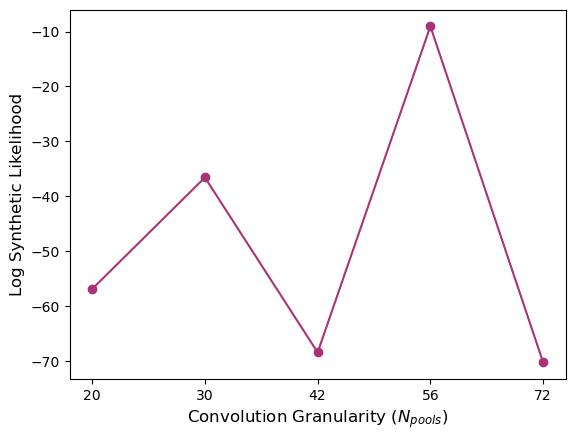

In [47]:
s = np.asarray(DistFix_no_drift.groupby(['input_noise'])['distance_to_spaceship_log'].mean())

loglik_dict = {}

for convolution_granularity in ['20', '30', '42', '56', '72']:  # N_pools = 12 didn't manage to complete harder levels
    
    y_star = simulated_action_goals[simulated_action_goals.convolution_granularity == convolution_granularity]
    s_stats = (y_star.groupby(['input_noise_magnitude', 'level'])['distance_to_spaceship_log'].mean()).to_list()
    s_star = np.array_split(np.array(s_stats),3)

    loglik = calc_likelihood(s_star, s, single_stat=True, debugme='no')
    
    loglik_dict[convolution_granularity] = loglik
    
# plotting
lists = sorted(loglik_dict.items())
convGran, logSynthLik = zip(*lists)
plt.plot(convGran, logSynthLik, marker='o', color='#AA3377', markersize=6)
plt.xlabel('Convolution Granularity ($N_{pools}$)', fontsize=12)
plt.ylabel('Log Synthetic Likelihood', fontsize=12)
plt.show()